# Plotting of Evaluation Results

You need to run `aggregator.py` first. Specify which results to aggregate in `settings.py`.

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('transformed/hc_0.3+/gts_ce_149.graphml/flow/t-metrics.csv',
                 names=['Time', 'Value', 'Metric', 'Algorithm'])

In [51]:
df.head()

,Time,Value,Metric,Algorithm
0,0,49,total_flows,gpasp
1,0,0,successful_flows,gpasp
2,0,0,dropped_flows,gpasp
3,0,49,in_network_flows,gpasp
4,100,1165,total_flows,gpasp


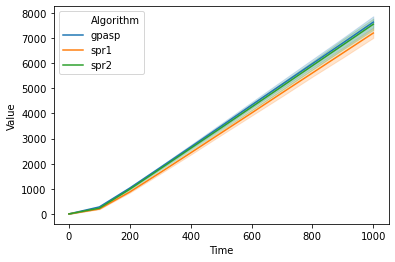

In [52]:
# plot successful flows with seaborn (needs long format)
df_successful = df[df['Metric'] == 'successful_flows']
sns.lineplot(df_successful['Time'], df_successful['Value'], hue=df_successful['Algorithm'])

In [53]:
def long_to_wide(df, alg):
    """Convert the long df to wide layout. Extract data for specified algorithm. Calculate total, % successful flows."""
    # long to wide
    df_alg = df[df['Algorithm'] == alg]
    df_wide = df_alg[df_alg['Metric'] == 'successful_flows'][['Time', 'Value']]
    df_wide.rename(columns={'Value': 'Successful'}, inplace=True)
    # extract dropped flows
    df_tmp = df_alg[df_alg['Metric'] == 'dropped_flows'][['Time', 'Value']]
    df_tmp.rename(columns={'Value': 'Dropped'}, inplace=True)
    df_wide = pd.merge(df_wide, df_tmp, on='Time')
    # extract in-network flows
    df_tmp = df_alg[df_alg['Metric'] == 'in_network_flows'][['Time', 'Value']]
    df_tmp.rename(columns={'Value': 'In-network'}, inplace=True)
    df_wide = pd.merge(df_wide, df_tmp, on='Time')
    
    # calc total and % succesful flows
    df_wide['Total'] = df_wide['Successful'] + df_wide['Dropped'] + df_wide['In-network']
    df_wide['% Successful'] = df_wide['Successful'] / df_wide['Total']
    return df_wide
    
df_gpasp = long_to_wide(df, 'gpasp')
df_spr1 = long_to_wide(df, 'spr1')
df_spr2 = long_to_wide(df, 'spr2')
df_gpasp.head()

,Time,Successful,Dropped,In-network,Total,% Successful
0,0,0,0,49,49,0.0
1,0,0,0,49,49,0.0
2,0,0,0,45,45,0.0
3,0,0,0,51,51,0.0
4,0,0,0,48,48,0.0


In [54]:
def df_mean_std(df, group_by=['Time']):
    """Return 2 new dfs with 1) average and 2) std values"""
    df_mean = df.groupby(group_by).mean().reset_index()
    df_std = df.groupby(group_by).std().reset_index()
    return df_mean, df_std

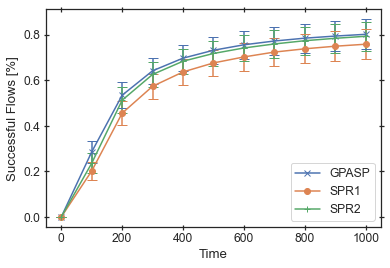

In [59]:
def plot_successful(dfs, labels, markers):
    """Plot % successful flows for the different algorithms"""
    assert len(dfs) == len(labels) == len(markers)
    fig, ax = plt.subplots()
    sns.set(font_scale=1.1, style='white')
    
    for i in range(len(dfs)):
        df_mean, df_std = df_mean_std(dfs[i])
        ax.errorbar(df_mean['Time'], df_mean['% Successful'], yerr=df_std['% Successful'], capsize=5,
                    label=labels[i], marker=markers[i])
        
    ax.set_xlabel('Time')
    ax.set_ylabel('Successful Flows [%]')
    ax.tick_params(axis='both', direction='inout', length=5, bottom=True, left=True, right=True, top=True)
    
    # remove error bars from legend: https://stackoverflow.com/a/15551976/2745116
    # get handles
    handles, labels = ax.get_legend_handles_labels()
    # remove the errorbars
    handles = [h[0] for h in handles]
    # use them in the legend
    ax.legend(handles, labels, numpoints=1)
    # ax.legend()
    
plot_successful(dfs=[df_gpasp, df_spr1, df_spr2], labels=['GPASP', 'SPR1', 'SPR2'], markers=['x', 'o', '+'])